In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import emoji
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from gensim.models import Word2Vec
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchtext.vocab import build_vocab_from_iterator
import warnings
import transformers
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm
from torchtext.vocab import build_vocab_from_iterator
import pickle
from tqdm import tqdm
import random


In [1]:
import zipfile

zip_path = '/home/jupyter/datasphere/project/dl-2025-study-competition-2.zip'
extract_path = '/home/jupyter/datasphere/project/competition_2'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print(f"Архив распакован в {extract_path}")

Архив распакован в /home/jupyter/datasphere/project/competition_2


# Пункт 1


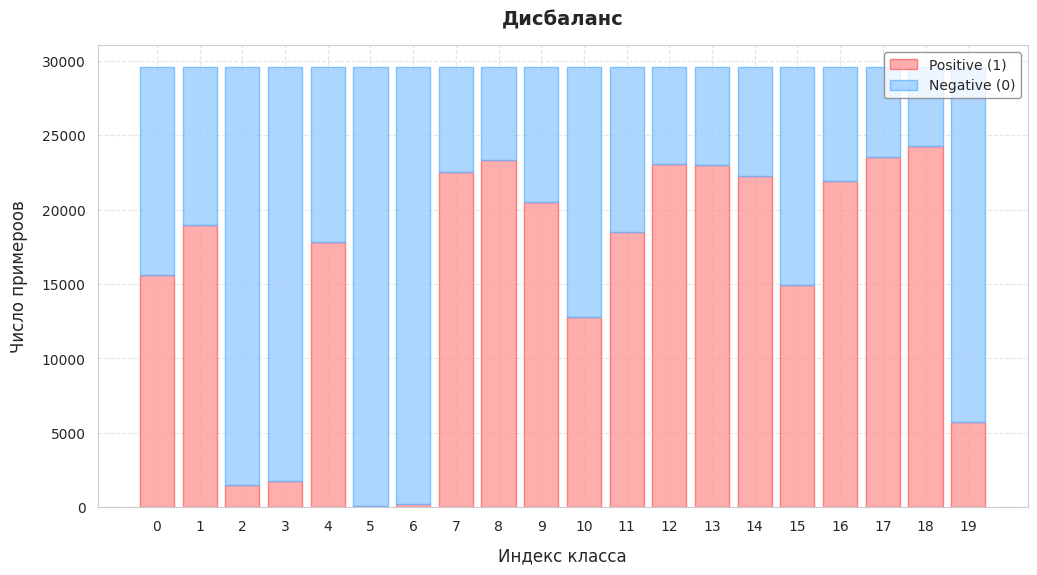

Количество классов: 20
Средняя доля положительных меток на класс: 0.528
Средняя длина текста: 604.81
Медианная длина текста: 592.00
Максимальная длина текста: 4081.00

Примеры текстов:
Текст 1: 15 января
Детская развлекательная программа
15-00 бесплатно
❗️
@
cafeotdyh
Кафе "Отдых"
📍
Запись обязательно +73472228532
Метки: [1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1]


Топ-5 частых слов:
[('и', 76596), ('в', 68666), ('на', 38065), ('по', 30380), ('-', 23131)]

Доля текстов с эмодзи: 0.635
Доля текстов с упоминаниями (@): 0.404
Доля текстов с хэштегами (#): 0.248


In [4]:
train_df = pd.read_csv('/home/jupyter/datasphere/project/competition_2/train.csv') 
test_df = pd.read_csv('/home/jupyter/datasphere/project/competition_2/test.csv')   
train_df['labels'] = train_df['labels'].apply(lambda x: [int(i) for i in x.split()])

#баланс классов
labels_array = np.array(train_df['labels'].tolist())
class_counts = labels_array.sum(axis=0)
n_classes = len(class_counts)
#график баланса
sns.set_style("whitegrid")
plt.figure(figsize=(12, 6), dpi=100)
plt.bar(range(n_classes), class_counts, label='Positive (1)', color='#ff9999', alpha=0.8, edgecolor='#ff6666')
plt.bar(range(n_classes), len(train_df) - class_counts, bottom=class_counts, label='Negative (0)', color='#99ccff', alpha=0.8, edgecolor='#66b3ff')
plt.xlabel('Индекс класса', fontsize=12, labelpad=10)
plt.ylabel('Число примероов', fontsize=12, labelpad=10)
plt.title('Дисбаланс', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(n_classes), fontsize=10)
plt.yticks(fontsize=10)
plt.tick_params(axis='both', which='major', length=5, width=1)
plt.show()
#информация
print(f"Количество классов: {n_classes}")
print(f"Средняя доля положительных меток на класс: {class_counts.mean() / len(train_df):.3f}")
train_df['text_length'] = train_df['text'].apply(len)
print(f"Средняя длина текста: {train_df['text_length'].mean():.2f}")
print(f"Медианная длина текста: {train_df['text_length'].median():.2f}")
print(f"Максимальная длина текста: {train_df['text_length'].max():.2f}")
print("\nПримеры текстов:")
for i in range(1):
    print(f"Текст {i+1}: {train_df['text'].iloc[i]}")
    print(f"Метки: {train_df['labels'].iloc[i]}\n")
words = ' '.join(train_df['text']).split()
word_freq = Counter(words)
print("\nТоп-5 частых слов:")
print(word_freq.most_common(5))

#процент дополнительных знаков
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"
                           u"\U0001F300-\U0001F5FF"
                           u"\U0001F680-\U0001F6FF"
                           u"\U0001F1E0-\U0001F1FF"
                           "]+", flags=re.UNICODE)
has_emoji = train_df['text'].apply(lambda x: bool(emoji_pattern.search(x)))
has_mentions = train_df['text'].str.contains(r'@\w+')
has_hashtags = train_df['text'].str.contains(r'#\w+')

print(f"\nДоля текстов с эмодзи: {has_emoji.mean():.3f}")
print(f"Доля текстов с упоминаниями (@): {has_mentions.mean():.3f}")
print(f"Доля текстов с хэштегами (#): {has_hashtags.mean():.3f}")

----------------------------------------------------------------------------------
Тексты с описаниями различных общественных событий: включают даты, номера телефонов, эмодзи и т.д. Классы несбалансированы. Тексты средней длины.

# Пункт 2

In [5]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

#пайплайн для TF-IDF
def clean_text_tfidf(text):
    text = text.lower()
    text = emoji.demojize(text, language='ru')
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

#пайплайн для Word2Vec
def clean_text_w2v(text):
    text = text.lower()
    text = re.sub(r'@\w+|#\w+|[^\w\s]|\d+', '', text) 
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

#пайплайн для CNN,RNN
def clean_text_cnn_rnn(text):
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

#пайплайн для BERT
def clean_text_bert(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip() 
    text = re.sub(r'\n+', ' ', text).strip()
    return text

train_df['text_tfidf'] = train_df['text'].apply(clean_text_tfidf)
train_df['text_w2v'] = train_df['text'].apply(clean_text_w2v)
train_df['text_cnn_rnn'] = train_df['text'].apply(clean_text_cnn_rnn)
train_df['text_bert'] = train_df['text'].apply(clean_text_bert)

test_df['text_tfidf'] = test_df['text'].apply(clean_text_tfidf)
test_df['text_w2v'] = test_df['text'].apply(clean_text_w2v)
test_df['text_cnn_rnn'] = test_df['text'].apply(clean_text_cnn_rnn)
test_df['text_bert'] = test_df['text'].apply(clean_text_bert)

train_df.to_csv('train_processed.csv', index=False)
test_df.to_csv('test_processed.csv', index=False)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#%pip install emoji

# Пункт 3

In [7]:
X = train_df[['text_tfidf', 'text_w2v', 'text_cnn_rnn', 'text_bert']]
y = np.array(train_df['labels'].tolist())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

## 3.1 TF-IDL + MLP

Эпоха 0, Train Loss: 0.6908, Val Loss: 0.6876, Val F1: 0.3111
Эпоха 1, Train Loss: 0.6875, Val Loss: 0.6838, Val F1: 0.4176
Эпоха 2, Train Loss: 0.6838, Val Loss: 0.6792, Val F1: 0.4881
Эпоха 3, Train Loss: 0.6791, Val Loss: 0.6735, Val F1: 0.5453
Эпоха 4, Train Loss: 0.6734, Val Loss: 0.6670, Val F1: 0.5569
Эпоха 5, Train Loss: 0.6668, Val Loss: 0.6595, Val F1: 0.5761
Эпоха 6, Train Loss: 0.6593, Val Loss: 0.6510, Val F1: 0.5842
Эпоха 7, Train Loss: 0.6509, Val Loss: 0.6417, Val F1: 0.5833
Эпоха 8, Train Loss: 0.6415, Val Loss: 0.6315, Val F1: 0.5805
Эпоха 9, Train Loss: 0.6313, Val Loss: 0.6206, Val F1: 0.5781
Эпоха 10, Train Loss: 0.6203, Val Loss: 0.6089, Val F1: 0.5765
Эпоха 11, Train Loss: 0.6086, Val Loss: 0.5968, Val F1: 0.5754
Эпоха 12, Train Loss: 0.5965, Val Loss: 0.5842, Val F1: 0.5746
Эпоха 13, Train Loss: 0.5839, Val Loss: 0.5714, Val F1: 0.5741
Эпоха 14, Train Loss: 0.5710, Val Loss: 0.5586, Val F1: 0.5739
Эпоха 15, Train Loss: 0.5583, Val Loss: 0.5460, Val F1: 0.5740
Ос

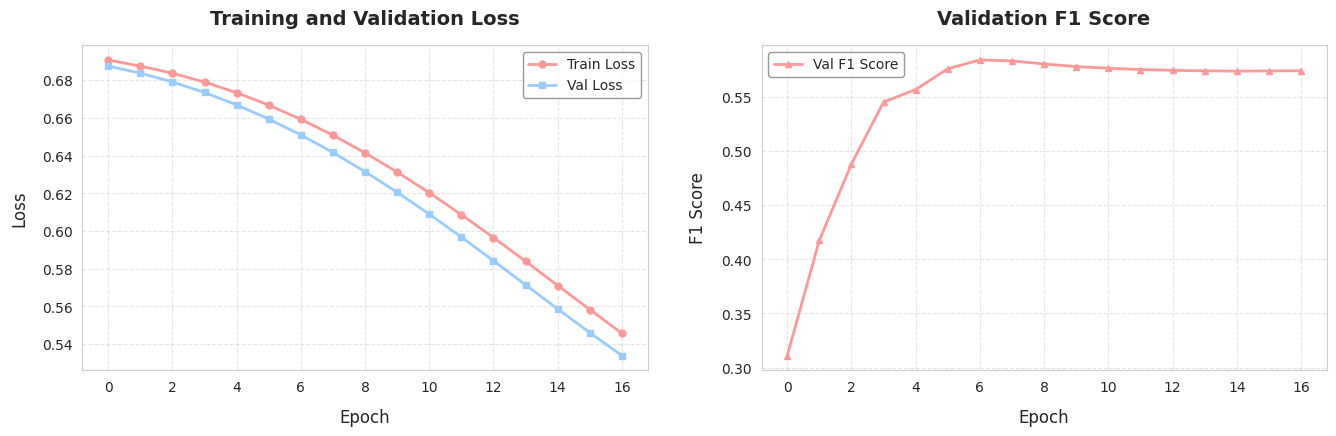

In [8]:
#векторизация
vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = vectorizer.fit_transform(X_train['text_tfidf']).toarray()
X_val_tfidf = vectorizer.transform(X_val['text_tfidf']).toarray()

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(input_dim=10000, hidden_dim=512, output_dim=n_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

#обучение
n_epochs = 50
best_f1 = 0
patience = 10
counter = 0
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    inputs = torch.FloatTensor(X_train_tfidf).to(device)
    targets = torch.FloatTensor(y_train).to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    model.eval()
    with torch.no_grad():
        inputs = torch.FloatTensor(X_val_tfidf).to(device)
        targets = torch.FloatTensor(y_val).to(device)
        outputs = model(inputs)
        val_loss = criterion(outputs, targets)
        val_losses.append(val_loss.item())
        preds = (torch.sigmoid(outputs) > 0.5).float()
        f1 = f1_score(targets.cpu(), preds.cpu(), average='macro')
        val_f1s.append(f1)
        
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model.state_dict(), 'best_mlp.pth')
            counter = 0
        else:
            counter += 1

        scheduler.step(val_loss)
        
        if counter >= patience:
            print(f"Остановлено на эпохе {epoch}")
            break
    
    print(f"Эпоха {epoch}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val F1: {f1:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#ff9999', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Val Loss', color='#99ccff', linewidth=2, marker='s', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Training and Validation Loss', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 Score', color='#ff9999', linewidth=2, marker='^', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.title('Validation F1 Score', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=3.0)
plt.show()

## Word2Vec + LSTM

/tmp/ipykernel_29533/1889110010.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.FloatTensor(vectors) if vectors else torch.zeros((1, 100))


Эпоха 0, Train Loss: 0.5009, Val Loss: 0.4953, Val F1: 0.5403
Эпоха 1, Train Loss: 0.4980, Val Loss: 0.4939, Val F1: 0.5403
Эпоха 2, Train Loss: 0.4959, Val Loss: 0.4935, Val F1: 0.5410
Эпоха 3, Train Loss: 0.4959, Val Loss: 0.4942, Val F1: 0.5410
Эпоха 4, Train Loss: 0.4961, Val Loss: 0.4944, Val F1: 0.5410
Эпоха 5, Train Loss: 0.4960, Val Loss: 0.4957, Val F1: 0.5747
Эпоха 6, Train Loss: 0.4957, Val Loss: 0.4942, Val F1: 0.5410
Эпоха 7, Train Loss: 0.4952, Val Loss: 0.4937, Val F1: 0.5747
Эпоха 8, Train Loss: 0.4953, Val Loss: 0.4935, Val F1: 0.5747
Эпоха 9, Train Loss: 0.4951, Val Loss: 0.4934, Val F1: 0.5747
Ранняя остановка на эпохе 10


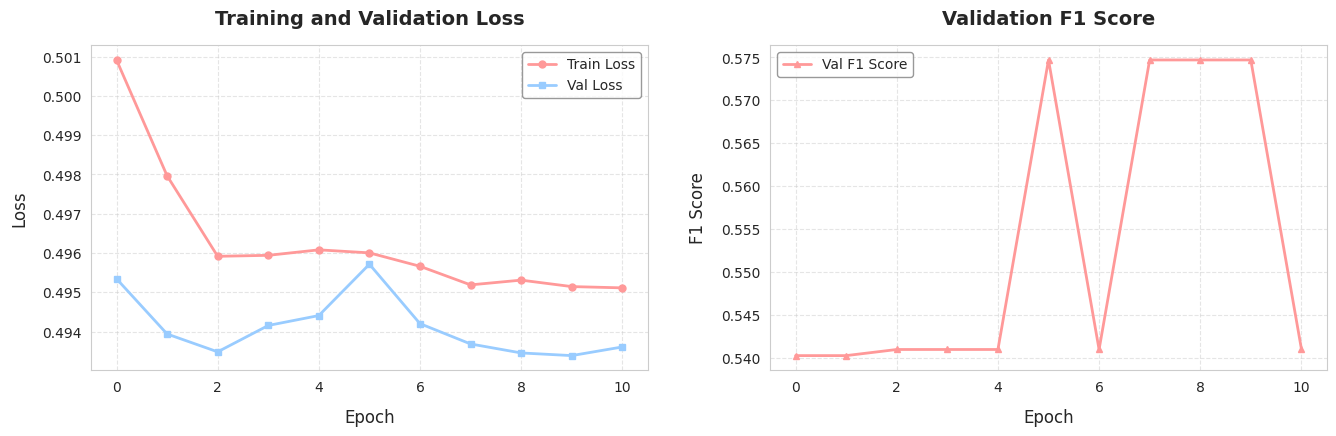

In [9]:
sentences = [text.split() for text in X_train['text_w2v']]
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

#токенизация и векторизация
def text_to_w2v(text, model, max_len=256):
    tokens = text.split()[:max_len]
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    return torch.FloatTensor(vectors) if vectors else torch.zeros((1, 100))

X_train_w2v = [text_to_w2v(text, w2v_model) for text in X_train['text_w2v']]
X_val_w2v = [text_to_w2v(text, w2v_model) for text in X_val['text_w2v']]
X_train_w2v = pad_sequence(X_train_w2v, batch_first=True).to(device)
X_val_w2v = pad_sequence(X_val_w2v, batch_first=True).to(device)

#модель LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        x = self.dropout(hn[-1])
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LSTMModel(input_dim=100, hidden_dim=512, output_dim=n_classes).to(device) 
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

train_dataset = TensorDataset(X_train_w2v, torch.FloatTensor(y_train).to(device))
val_dataset = TensorDataset(X_val_w2v, torch.FloatTensor(y_val).to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#Обучение
n_epochs = 50
best_f1 = 0
patience = 5
counter = 0
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device) 
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    preds, true = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            preds.append((torch.sigmoid(outputs) > 0.5).float().cpu())
            true.append(targets.cpu())
    val_losses.append(val_loss / len(val_loader))
    preds = torch.cat(preds).numpy()
    true = torch.cat(true).numpy()
    f1 = f1_score(true, preds, average='macro')
    val_f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_lstm.pth')
        counter = 0
    else:
        counter += 1
    
    scheduler.step(val_loss)
    
    if counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        break
    
    print(f"Эпоха {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {f1:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#ff9999', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Val Loss', color='#99ccff', linewidth=2, marker='s', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Training and Validation Loss', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 Score', color='#ff9999', linewidth=2, marker='^', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.title('Validation F1 Score', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=3.0)
plt.show()

## CNN с встроенным эмбеддингом

Эпоха 0, Train Loss: 0.4195, Val Loss: 0.3445, Val F1: 0.6934
Эпоха 1, Train Loss: 0.3554, Val Loss: 0.3556, Val F1: 0.7098
Эпоха 2, Train Loss: 0.3210, Val Loss: 0.4497, Val F1: 0.7184
Эпоха 3, Train Loss: 0.3013, Val Loss: 0.4998, Val F1: 0.7075
Эпоха 4, Train Loss: 0.2906, Val Loss: 0.6152, Val F1: 0.7143
Эпоха 5, Train Loss: 0.2514, Val Loss: 0.5925, Val F1: 0.7308
Эпоха 6, Train Loss: 0.2269, Val Loss: 0.6801, Val F1: 0.7301
Эпоха 7, Train Loss: 0.2166, Val Loss: 0.7266, Val F1: 0.7418
Эпоха 8, Train Loss: 0.2095, Val Loss: 0.7970, Val F1: 0.7421
Эпоха 9, Train Loss: 0.1889, Val Loss: 0.8217, Val F1: 0.7537
Эпоха 10, Train Loss: 0.1766, Val Loss: 0.8551, Val F1: 0.7490
Эпоха 11, Train Loss: 0.1688, Val Loss: 0.9284, Val F1: 0.7580
Эпоха 12, Train Loss: 0.1632, Val Loss: 0.9776, Val F1: 0.7564
Эпоха 13, Train Loss: 0.1527, Val Loss: 0.9930, Val F1: 0.7642
Эпоха 14, Train Loss: 0.1467, Val Loss: 1.0172, Val F1: 0.7617
Эпоха 15, Train Loss: 0.1425, Val Loss: 1.0654, Val F1: 0.7658
Эп

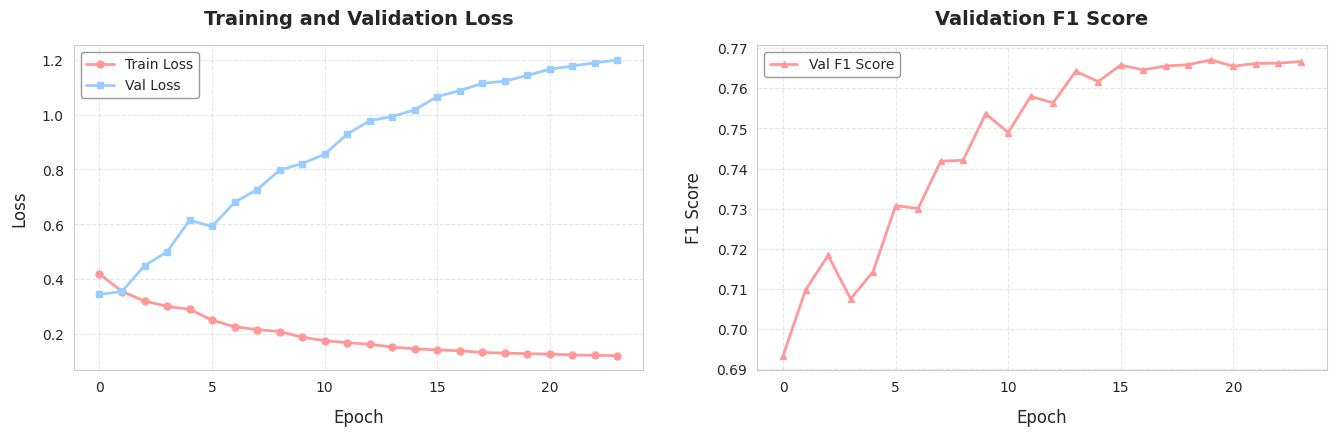

In [10]:


#токенизация
def tokenizer(text):
    return text.split()
vocab = build_vocab_from_iterator(map(tokenizer, X_train['text_cnn_rnn']), specials=['<pad>', '<unk>'])
vocab.set_default_index(vocab['<unk>'])
def text_to_indices(text, vocab, max_len=50):
    tokens = tokenizer(text)[:max_len]
    indices = [vocab[token] for token in tokens]
    return torch.LongTensor(indices)

X_train_cnn = [text_to_indices(text, vocab) for text in X_train['text_cnn_rnn']]
X_val_cnn = [text_to_indices(text, vocab) for text in X_val['text_cnn_rnn']]
X_train_cnn = pad_sequence(X_train_cnn, batch_first=True).to(device)
X_val_cnn = pad_sequence(X_val_cnn, batch_first=True).to(device)
y_train = np.array(y_train)
y_val = np.array(y_val)


#модель CNN
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, n_filters, filter_sizes, output_dim):
        super(CNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, n_filters, fs) for fs in filter_sizes
        ])
        self.fc = nn.Linear(n_filters * len(filter_sizes), output_dim)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1) 
        x = [torch.relu(conv(x)) for conv in self.convs]
        x = [torch.max(xi, dim=2)[0] for xi in x] 
        x = torch.cat(x, dim=1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(vocab)
embed_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]
n_classes = y_train.shape[1] 
model = CNNModel(vocab_size, embed_dim, n_filters, filter_sizes, n_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

train_dataset = TensorDataset(X_train_cnn, torch.FloatTensor(y_train).to(device))
val_dataset = TensorDataset(X_val_cnn, torch.FloatTensor(y_val).to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#обучение
n_epochs = 50
best_f1 = 0
patience = 4
counter = 0
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    preds, true = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            preds.append((torch.sigmoid(outputs) > 0.5).float().cpu())
            true.append(targets.cpu())
    val_losses.append(val_loss / len(val_loader))
    preds = torch.cat(preds).numpy()
    true = torch.cat(true).numpy()
    f1 = f1_score(true, preds, average='macro') 
    val_f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_cnn.pth') 
        counter = 0
    else:
        counter += 1
    
    scheduler.step(val_loss)
    
    if counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        break
    
    print(f"Эпоха {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {f1:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#ff9999', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Val Loss', color='#99ccff', linewidth=2, marker='s', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Training and Validation Loss', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 Score', color='#ff9999', linewidth=2, marker='^', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.title('Validation F1 Score', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=3.0)
plt.show()

## RNN с встроенным эмбеддингом

Эпоха 0, Train Loss: 0.4014, Val Loss: 0.3720, Val F1: 0.6700
Эпоха 1, Train Loss: 0.3771, Val Loss: 0.3645, Val F1: 0.6691
Эпоха 2, Train Loss: 0.3629, Val Loss: 0.3503, Val F1: 0.6702
Эпоха 3, Train Loss: 0.3586, Val Loss: 0.3568, Val F1: 0.6733
Эпоха 4, Train Loss: 0.3463, Val Loss: 0.3567, Val F1: 0.6762
Эпоха 5, Train Loss: 0.3364, Val Loss: 0.3581, Val F1: 0.6704
Эпоха 6, Train Loss: 0.3290, Val Loss: 0.3695, Val F1: 0.6648
Эпоха 7, Train Loss: 0.3191, Val Loss: 0.3615, Val F1: 0.6639
Эпоха 8, Train Loss: 0.3052, Val Loss: 0.3600, Val F1: 0.6775
Эпоха 9, Train Loss: 0.3025, Val Loss: 0.3592, Val F1: 0.6811
Эпоха 10, Train Loss: 0.2935, Val Loss: 0.3672, Val F1: 0.6838
Эпоха 11, Train Loss: 0.2916, Val Loss: 0.3631, Val F1: 0.6771
Эпоха 12, Train Loss: 0.2860, Val Loss: 0.3635, Val F1: 0.6906
Эпоха 13, Train Loss: 0.2737, Val Loss: 0.3591, Val F1: 0.6935
Эпоха 14, Train Loss: 0.2672, Val Loss: 0.3609, Val F1: 0.6900
Эпоха 15, Train Loss: 0.2657, Val Loss: 0.3619, Val F1: 0.6912
Эп

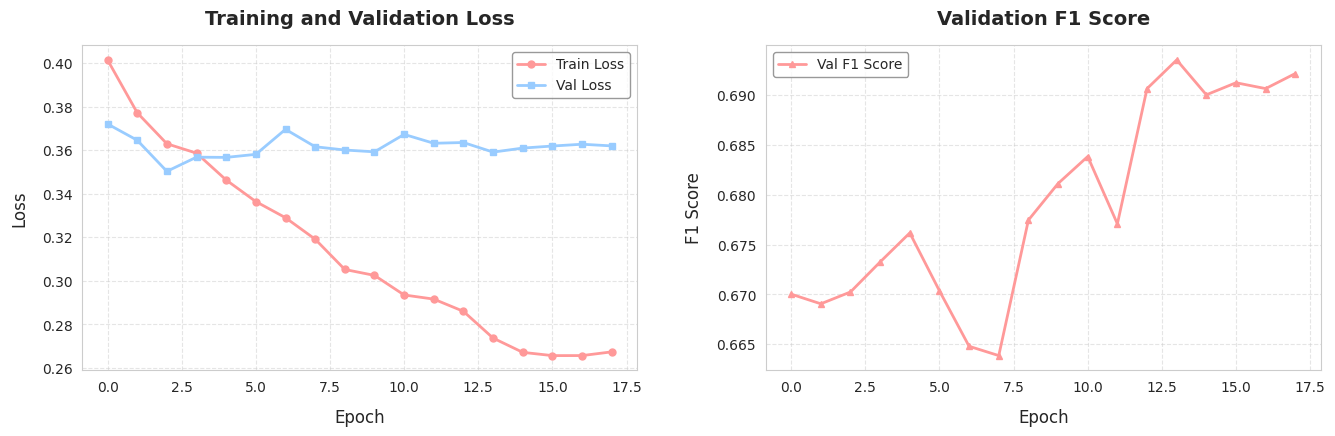

In [11]:
def tokenizer(text):
    return text.split()
vocab = build_vocab_from_iterator(map(tokenizer, X_train['text_cnn_rnn']), specials=['<pad>', '<unk>'])
vocab.set_default_index(vocab['<unk>'])

def text_to_indices(text, vocab, max_len=50):
    tokens = tokenizer(text)[:max_len]
    indices = [vocab[token] for token in tokens]
    return torch.LongTensor(indices)
X_train_rnn = [text_to_indices(text, vocab) for text in X_train['text_cnn_rnn']]
X_val_rnn = [text_to_indices(text, vocab) for text in X_val['text_cnn_rnn']]
X_train_rnn = pad_sequence(X_train_rnn, batch_first=True).to(device)
X_val_rnn = pad_sequence(X_val_rnn, batch_first=True).to(device)
y_train = np.array(y_train)
y_val = np.array(y_val)
#модель RNN
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.7)
    
    def forward(self, x):
        x = self.embedding(x) 
        _, hn = self.rnn(x) 
        x = self.dropout(hn[-1])  
        x = self.fc(x)  
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(vocab)
embed_dim = 100
hidden_dim = 256
n_classes = y_train.shape[1] 
model = RNNModel(vocab_size, embed_dim, hidden_dim, n_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=4, factor=0.5)

train_dataset = TensorDataset(X_train_rnn, torch.FloatTensor(y_train).to(device))
val_dataset = TensorDataset(X_val_rnn, torch.FloatTensor(y_val).to(device))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

#обучение
n_epochs = 50
best_f1 = 0
patience = 4
counter = 0
train_losses, val_losses, val_f1s = [], [], []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    preds, true = [], []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
            preds.append((torch.sigmoid(outputs) > 0.5).float().cpu())
            true.append(targets.cpu())
    val_losses.append(val_loss / len(val_loader))
    preds = torch.cat(preds).numpy()
    true = torch.cat(true).numpy()
    f1 = f1_score(true, preds, average='macro') 
    val_f1s.append(f1)
    
    # Сохранение лучшей модели
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_rnn.pth') 
        counter = 0
    else:
        counter += 1
    
    scheduler.step(val_loss)
    
    if counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        break
    
    print(f"Эпоха {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {f1:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#ff9999', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Val Loss', color='#99ccff', linewidth=2, marker='s', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Training and Validation Loss', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 Score', color='#ff9999', linewidth=2, marker='^', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.title('Validation F1 Score', fontsize=14, pad=15, fontweight='bold')
plt.legend(fontsize=10, loc='best', frameon=True, facecolor='white', edgecolor='gray')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=3.0)
plt.show()

# BERT-like модель  - лучший скор на Kaggle

## RuBert-модель 
- обучалась на русскоязычных данных, хорошо понимает контекст, может работать на данных с минимальной очисткой

In [ ]:
#%pip install transformers

/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
Validation: 100%|██████████| 370/370 [00:50<00:00,  7.37it/s]


Эпоха 0, Train Loss: 0.5140, Val Loss: 0.4068, Val F1: 0.7683


Validation: 100%|██████████| 370/370 [00:50<00:00,  7.38it/s]


Эпоха 1, Train Loss: 0.3346, Val Loss: 0.3288, Val F1: 0.8124


Validation: 100%|██████████| 370/370 [00:50<00:00,  7.38it/s]


Эпоха 2, Train Loss: 0.2645, Val Loss: 0.2918, Val F1: 0.8392


Validation: 100%|██████████| 370/370 [00:50<00:00,  7.38it/s]


Эпоха 3, Train Loss: 0.2200, Val Loss: 0.3137, Val F1: 0.8626


Validation: 100%|██████████| 370/370 [00:50<00:00,  7.37it/s]


Эпоха 4, Train Loss: 0.1833, Val Loss: 0.2827, Val F1: 0.8571


Validation: 100%|██████████| 370/370 [00:50<00:00,  7.38it/s]


Эпоха 5, Train Loss: 0.1449, Val Loss: 0.2868, Val F1: 0.8828


Validation: 100%|██████████| 370/370 [00:50<00:00,  7.37it/s]


Эпоха 6, Train Loss: 0.1140, Val Loss: 0.2932, Val F1: 0.8839


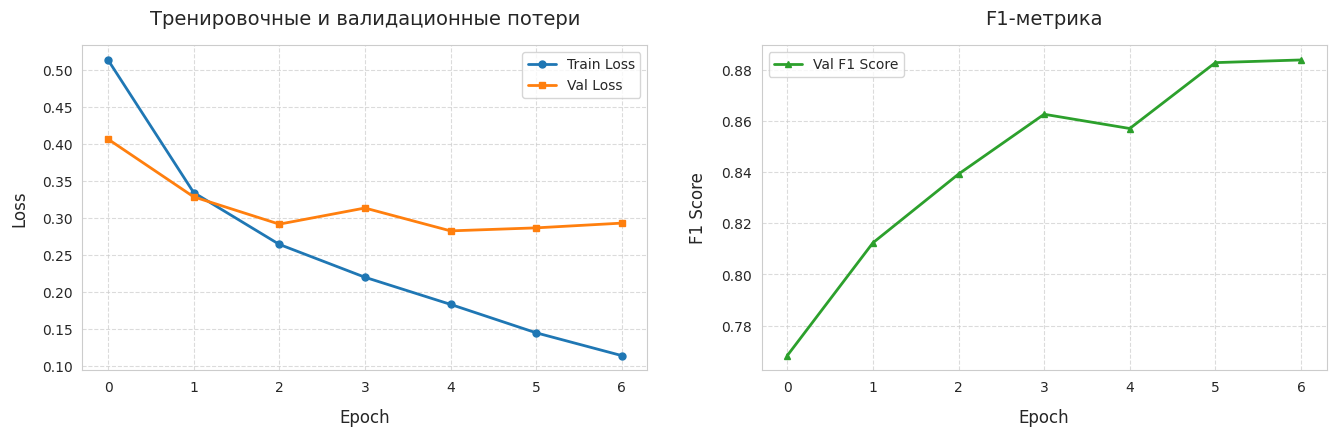

In [14]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch")  
transformers.logging.set_verbosity_error()

class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        if self.labels is not None:
            item['labels'] = torch.FloatTensor(self.labels[idx])
        return item

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_len = 256
batch_size = 16  
n_classes = y_train.shape[1]  
n_epochs = 7 #небольшого числа эпох хватает
lr = 2e-5 

#токенизатор и модель
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased') 
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=n_classes,
    problem_type='multi_label_classification'
).to(device)

train_dataset = TextDataset(X_train['text_bert'].values, y_train, tokenizer, max_len)
val_dataset = TextDataset(X_val['text_bert'].values, y_val, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
pos_weights = torch.tensor([1.0 / (y_train[:, i].mean() + 1e-6) for i in range(n_classes)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)   #вычисляет потерю независимо для каждой метки

#обучение
train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
patience = 3
counter = 0

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    preds, true = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            val_loss += criterion(outputs.logits, labels).item()
            preds.append((torch.sigmoid(outputs.logits) > 0.5).float().cpu())
            true.append(labels.cpu())
    val_losses.append(val_loss / len(val_loader))
    preds = torch.cat(preds).numpy()
    true = torch.cat(true).numpy()
    f1 = f1_score(true, preds, average='macro')
    val_f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_bert.pth')
        counter = 0
    else:
        counter += 1
    
    scheduler.step(val_loss)
    
    if counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        break
    
    print(f"Эпоха {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {f1:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#ff9999', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Val Loss', color='#99ccff', linewidth=2, marker='s', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Тренировочные и валидационные потери', fontsize=14, pad=15)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 Score', color='#ff9999', linewidth=2, marker='^', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.title('F1-метрика', fontsize=14, pad=15)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=3.0)
plt.show()


In [15]:
test_dataset = TextDataset(test_df['text_bert'].values, tokenizer=tokenizer, max_len=max_len)
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.load_state_dict(torch.load('best_bert.pth'))
model.eval()
predictions = []
with torch.no_grad():
    for batch in tqdm(test_loader, desc="Predicting"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        preds = (torch.sigmoid(outputs.logits) > 0.5).float().cpu().numpy()
        predictions.extend(preds)
labels = [' '.join(map(str, pred.astype(int))) for pred in predictions]
test_ids = test_df['id'] if 'id' in test_df.columns else list(range(len(predictions)))
results = pd.DataFrame({'id': test_ids, 'labels': labels})
results.to_csv('test_predictions_bert.csv', index=False)
print("Предсказания сохранены в 'test_predictions_bert.csv'")

Predicting: 100%|██████████| 462/462 [01:01<00:00,  7.47it/s]


Предсказания сохранены в 'test_predictions_bert.csv'


In [32]:
#%pip uninstall torch transformers
#%pip install torch==2.0.0 transformers==4.41.2

# Пункт 4

In [18]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
transformers.logging.set_verbosity_error()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
label_probs = y_train.mean(axis=0)
print("Вероятности меток:", label_probs)

def yield_tokens(texts):
    for text in texts:
        yield text.split() 

vocab = build_vocab_from_iterator(yield_tokens(X_train['text_bert'].values), specials=['<unk>', '<pad>'])
vocab.set_default_index(vocab['<unk>'])
pad_idx = vocab['<pad>']

class LSTMDataset(Dataset):
    def __init__(self, texts, vocab, max_len=100):
        self.texts = texts
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx].split()
        tokens = [self.vocab[token] for token in text[:self.max_len]]
        if len(tokens) < self.max_len:
            tokens += [pad_idx] * (self.max_len - len(tokens))
        return torch.tensor(tokens[:self.max_len], dtype=torch.long)

#декодер
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, hidden=None):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out)
        return output, hidden

    def generate(self, max_len, start_token=0, temperature=1.0):
        self.eval()
        generated = [start_token]
        hidden = None
        with torch.no_grad():
            for _ in range(max_len - 1):
                input_tensor = torch.tensor([generated[-1]], dtype=torch.long).unsqueeze(0).to(device)
                output, hidden = self(input_tensor, hidden)
                probs = torch.softmax(output[:, -1, :] / temperature, dim=-1)
                next_token = torch.multinomial(probs, 1).item()
                generated.append(next_token)
                if next_token == pad_idx:
                    break
        
        return generated
    
def train_lstm(model, train_loader, criterion, optimizer, n_epochs=5):
    model.train()
    for epoch in range(n_epochs):
        epoch_loss = 0
        for batch in tqdm(train_loader, desc=f"LSTM Epoch {epoch}"):
            inputs = batch[:, :-1].to(device)
            targets = batch[:, 1:].to(device)
            optimizer.zero_grad()
            outputs, _ = model(inputs)
            loss = criterion(outputs.reshape(-1, outputs.size(-1)), targets.reshape(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"LSTM Epoch {epoch}, Loss: {epoch_loss / len(train_loader):.4f}")
#подготовка данных
lstm_dataset = LSTMDataset(X_train['text_bert'].values, vocab, max_len=100)
lstm_loader = DataLoader(lstm_dataset, batch_size=32, shuffle=True)
vocab_size = len(vocab)
embed_size = 128
hidden_size = 256
num_layers = 1
lstm_model = LSTMDecoder(vocab_size, embed_size, hidden_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)

#обучение
train_lstm(lstm_model, lstm_loader, criterion, optimizer, n_epochs=5)

LSTM Epoch 0: 100%|██████████| 740/740 [03:00<00:00,  4.10it/s]


LSTM Epoch 0, Loss: 8.7839


LSTM Epoch 1: 100%|██████████| 740/740 [03:02<00:00,  4.06it/s]


LSTM Epoch 1, Loss: 6.9269


LSTM Epoch 2: 100%|██████████| 740/740 [03:02<00:00,  4.05it/s]


LSTM Epoch 2, Loss: 5.7182


LSTM Epoch 3: 100%|██████████| 740/740 [03:03<00:00,  4.04it/s]


LSTM Epoch 3, Loss: 4.9169


LSTM Epoch 4: 100%|██████████| 740/740 [03:03<00:00,  4.04it/s]

LSTM Epoch 4, Loss: 4.3134


In [19]:
n_samples = 1000
max_len = 100

generated_texts = []
generated_labels = []
for _ in tqdm(range(n_samples), desc="Generating texts"):
    tokens = lstm_model.generate(max_len=max_len, temperature=0.8)
    text = ' '.join([vocab.get_itos()[token] for token in tokens if token != pad_idx])
    generated_texts.append(text)
    labels = np.random.binomial(1, label_probs)
    generated_labels.append(labels)

generated_df = pd.DataFrame({
    'text_bert': generated_texts,
    'labels': [' '.join(map(str, label)) for label in generated_labels]
})

generated_labels = np.array([list(map(int, label.split())) for label in generated_df['labels']])
print(generated_df.head())

#объединение данных
X_train_augmented = pd.concat([X_train, generated_df[['text_bert']]], ignore_index=True)
y_train_augmented = np.vstack([y_train, generated_labels])

Generating texts: 100%|██████████| 1000/1000 [1:16:22<00:00,  4.58s/it]


In [29]:
#пайплайн для BERT
def clean_text_bert(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text) 
    text = re.sub(r'\s+', ' ', text).strip() 
    text = re.sub(r'\n+', ' ', text).strip()
    return text

train_df['text_bert'] = X_train_augmented['text_bert'].apply(clean_text_bert)
#test_df['text_bert'] = test_df['text'].apply(clean_text_bert)

In [30]:
X = train_df[['text_bert']]
y = np.array(train_df['labels'].tolist())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

Validation: 100%|██████████| 370/370 [00:48<00:00,  7.56it/s]


Эпоха 0, Train Loss: 0.8764, Val Loss: 0.8695, Val F1: 0.6286


Validation: 100%|██████████| 370/370 [00:48<00:00,  7.57it/s]


Эпоха 1, Train Loss: 0.8716, Val Loss: 0.8696, Val F1: 0.6291


Validation: 100%|██████████| 370/370 [00:48<00:00,  7.55it/s]


Эпоха 2, Train Loss: 0.8707, Val Loss: 0.8695, Val F1: 0.6288


Validation: 100%|██████████| 370/370 [00:48<00:00,  7.56it/s]


Эпоха 3, Train Loss: 0.8705, Val Loss: 0.8687, Val F1: 0.6291


Validation: 100%|██████████| 370/370 [00:48<00:00,  7.56it/s]


Ранняя остановка на эпохе 4


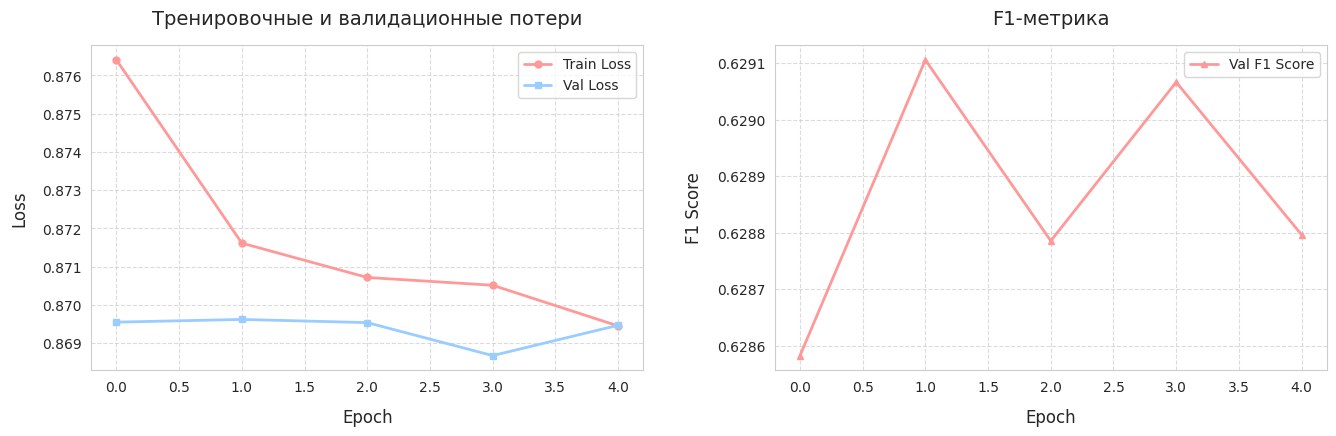

In [31]:
warnings.filterwarnings("ignore", category=UserWarning, module="torch")  
transformers.logging.set_verbosity_error()

class TextDataset(Dataset):
    def __init__(self, texts, labels=None, tokenizer=None, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        if self.labels is not None:
            item['labels'] = torch.FloatTensor(self.labels[idx])
        return item

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
max_len = 256
batch_size = 16  
n_classes = y_train.shape[1]  
n_epochs = 7 #небольшого числа эпох хватает
lr = 2e-5 

#токенизатор и модель
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased') 
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=n_classes,
    problem_type='multi_label_classification'
).to(device)

train_dataset = TextDataset(X_train['text_bert'].values, y_train, tokenizer, max_len)
val_dataset = TextDataset(X_val['text_bert'].values, y_val, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
pos_weights = torch.tensor([1.0 / (y_train[:, i].mean() + 1e-6) for i in range(n_classes)]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)   #вычисляет потерю независимо для каждой метки

#обучение
train_losses, val_losses, val_f1s = [], [], []
best_f1 = 0
patience = 3
counter = 0

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_losses.append(epoch_loss / len(train_loader))
    
    model.eval()
    val_loss = 0
    preds, true = [], []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            val_loss += criterion(outputs.logits, labels).item()
            preds.append((torch.sigmoid(outputs.logits) > 0.5).float().cpu())
            true.append(labels.cpu())
    val_losses.append(val_loss / len(val_loader))
    preds = torch.cat(preds).numpy()
    true = torch.cat(true).numpy()
    f1 = f1_score(true, preds, average='macro')
    val_f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_bert.pth')
        counter = 0
    else:
        counter += 1
    
    scheduler.step(val_loss)
    
    if counter >= patience:
        print(f"Ранняя остановка на эпохе {epoch}")
        break
    
    print(f"Эпоха {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val F1: {f1:.4f}")

sns.set_style("whitegrid")
plt.figure(figsize=(14, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', color='#ff9999', linewidth=2, marker='o', markersize=5)
plt.plot(val_losses, label='Val Loss', color='#99ccff', linewidth=2, marker='s', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.title('Тренировочные и валидационные потери', fontsize=14, pad=15)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.subplot(1, 2, 2)
plt.plot(val_f1s, label='Val F1 Score', color='#ff9999', linewidth=2, marker='^', markersize=5)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('F1 Score', fontsize=12, labelpad=10)
plt.title('F1-метрика', fontsize=14, pad=15)
plt.legend(fontsize=10, loc='best')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.tight_layout(pad=3.0)
plt.show()


Добавление новых сгенерированных данных к датасету привело к снижению F1-метрики на валидационной выборке.
Это может быть связано с тем, что LSTM-декодер, генерит данные которые не полностью соответствуют распределению реальных данных. 